# 02_clean and preprocess

**NOTA:** Este notebook ha sido modificado para cumplir con las mejores prácticas de Scikit-Learn, previniendo la **fuga de datos (data leakage)**.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Importaciones de Sklearn ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

# --- Importación de YData Profiling ---
try:
    from ydata_profiling import ProfileReport
except ImportError:
    print("Error: ydata-profiling no está instalado. Por favor, instálalo con: pip install ydata-profiling")
    ProfileReport = None

# =====================================================================
# CLASE: DataExplorer
# =====================================================================

class DataExplorer:
    """
    Clase estática para realizar un Análisis Exploratorio de Datos (EDA)
    y generar reportes de profiling.
    """

    @staticmethod
    def explore_data(data):
        """
        Realiza un EDA básico: muestra info, estadísticas y gráficos.
        """
        print("="*30)
        print("INICIANDO ANÁLISIS EXPLORATORIO (EDA)")
        print("="*30)
        
        print("\n--- Información General del DataFrame ---")
        data.info()
        
        print("\n--- Primeras 5 Filas ---")
        print(data.head())
        
        print("\n--- Estadísticas Descriptivas ---")
        try:
            numeric_features = data.select_dtypes(include=np.number)
            stats_num = DataExplorer.get_numeric_stats(numeric_features)
            print(stats_num)
        except Exception as e:
            print(f"No se pudieron calcular estadísticas descriptivas: {e}")

        DataExplorer.plot_correlation_matrix(data, title="Matriz de Correlación (Datos Crudos)")
        
        print("="*30)
        print("FIN DE ANÁLISIS EXPLORATORIO (EDA)")
        print("="*30)

    @staticmethod
    def get_numeric_stats(df_numeric: pd.DataFrame) -> pd.DataFrame:
        stats_num = df_numeric.describe().T
        stats_num['skew'] = df_numeric.skew()
        stats_num['kurtosis'] = df_numeric.kurtosis()
        return stats_num

    @staticmethod
    def plot_correlation_matrix(data, title="Matriz de Correlación", save_path=None):
        """
        Grafica un heatmap de correlación y opcionalmente lo guarda en save_path.
        """
        print(f"\n--- Generando Heatmap: {title} ---")
        plt.figure(figsize=(14, 12))
        try:
            corr_matrix = data.corr(numeric_only=True)
            sns.heatmap(corr_matrix, cmap='mako_r', annot=False)
            plt.title(title, fontsize=16)
            plt.tight_layout()
            
            if save_path:
                try:
                    os.makedirs(os.path.dirname(save_path), exist_ok=True)
                    plt.savefig(save_path, bbox_inches='tight')
                    print(f"Heatmap guardado en: {save_path}")
                except Exception as e:
                    print(f"Error al guardar el heatmap en {save_path}: {e}")
            
            plt.show()
            print(f"Heatmap '{title}' generado.")
        except Exception as e:
            print(f"No se pudo generar el heatmap de correlación '{title}': {e}")

    @staticmethod
    def generate_profiling_report(data, title, output_dir, filename):
        if ProfileReport is None:
            print(f"SKIPPING: Reporte de Profiling '{title}' (ydata-profiling no encontrado).")
            return
        output_path = os.path.join(output_dir, filename)
        print(f"\n--- Generando Reporte de Profiling: {title} ---")
        print(f"Guardando en: {output_path}")
        os.makedirs(output_dir, exist_ok=True)
        try:
            profile = ProfileReport(data, title=title, minimal=True)
            profile.to_file(output_path)
            print(f"Reporte '{filename}' guardado exitosamente.")
        except Exception as e:
            print(f"Error al generar el reporte de profiling: {e}")

# =====================================================================
# CLASE: DataCleaner
# =====================================================================

class DataCleaner:
    def __init__(self, df):
        self.df = df.copy()

    def filter_expected_columns(self, expected_cols):
        print("Filtrando columnas esperadas...")
        extra = [c for c in self.df.columns if c not in expected_cols]
        missing = [c for c in expected_cols if c not in self.df.columns]
        if extra: print(f"⚠️ Extras ignoradas: {extra}")
        if missing: print(f"⚠️ Faltan columnas: {missing}")
        self.df = self.df[[c for c in expected_cols if c in self.df.columns]]
        return self

    def force_numeric(self, exclude=["url"]):
        print("Forzando columnas a tipo numérico...")
        for c in self.df.columns:
            if c in exclude:
                continue
            if self.df[c].dtype == "O":
                self.df[c] = (
                    self.df[c].astype(str)
                    .str.replace(",", ".", regex=False)
                    .replace({"nan": np.nan, "None": np.nan, "": np.nan})
                )
            self.df[c] = pd.to_numeric(self.df[c], errors="coerce")
        return self

    def apply_business_rules(self):
        print("Aplicando reglas de negocio...")
        if "timedelta" in self.df:
            self.df["timedelta"] = self.df["timedelta"].clip(0, 731)
        clip_01 = ["n_unique_tokens", "global_subjectivity"]
        for c in clip_01:
            if c in self.df:
                self.df[c] = self.df[c].clip(0, 1)
        return self

    def normalize_lda(self, lda_cols=None):
        if not lda_cols: return self
        print("Normalizando columnas LDA...")
        lda_cols = [c for c in lda_cols if c in self.df]
        if lda_cols:
            s = self.df[lda_cols].sum(axis=1)
            mask = s > 0
            self.df.loc[mask, lda_cols] = self.df.loc[mask, lda_cols].div(s[mask], axis=0)
        return self

    def clean_primary_key(self, key="url"):
        print(f"Limpiando clave primaria '{key}'...")
        if key not in self.df.columns:
            print(f"Advertencia: Clave primaria '{key}' no encontrada para limpiar.")
            return self
            
        self.df = self.df[self.df[key].notna() & (self.df[key] != "")]
        self.df[key] = self.df[key].astype(str).str.strip().str.lower()
        self.df = self.df[self.df[key].str.startswith("http", na=False)]
        return self

    def get_df(self):
        return self.df

# =====================================================================
# FUNCIONES AUXILIARES
# =====================================================================

def classify_numeric_columns(df_numeric: pd.DataFrame) -> (list, list):
    cols_bin = [col for col in df_numeric.columns if set(df_numeric[col].dropna().unique()) <= {0, 1}]
    cols_no_bin = [col for col in df_numeric.columns if col not in cols_bin]
    print(f"Columnas binarias identificadas: {len(cols_bin)}")
    print(f"Columnas numéricas no binarias: {len(cols_no_bin)}")
    return cols_bin, cols_no_bin

# =====================================================================
# CLASE: NewsPopularityModel
# =====================================================================

class DataProcessor:
    """
    Clase principal refactorizada.
    """
    def __init__(self, filepath):
        self.filepath = filepath
        self.reports_path = '../docs/'
        self.model_pipeline = None 
        self.data = None
        self.X_train, self.X_test, self.y_train, self.y_test = [None] * 4
        
        self.expected_cols = [
            "url","timedelta","n_tokens_title","n_tokens_content","n_unique_tokens",
            "n_non_stop_words","n_non_stop_unique_tokens","num_hrefs","num_self_hrefs",
            "num_imgs","num_videos","average_token_length","num_keywords",
            "data_channel_is_lifestyle","data_channel_is_entertainment","data_channel_is_bus",
            "data_channel_is_socmed","data_channel_is_tech","data_channel_is_world",
            "kw_min_min","kw_max_min","kw_avg_min","kw_min_max","kw_max_max","kw_avg_max",
            "kw_min_avg","kw_max_avg","kw_avg_avg",
            "self_reference_min_shares","self_reference_max_shares","self_reference_avg_sharess",
            "weekday_is_monday","weekday_is_tuesday","weekday_is_wednesday","weekday_is_thursday",
            "weekday_is_friday","weekday_is_saturday","weekday_is_sunday","is_weekend",
            "LDA_00","LDA_01","LDA_02","LDA_03","LDA_04",
            "global_subjectivity","global_sentiment_polarity","global_rate_positive_words",
            "global_rate_negative_words","rate_positive_words","rate_negative_words",
            "avg_positive_polarity","min_positive_polarity","max_positive_polarity",
            "avg_negative_polarity","min_negative_polarity","max_negative_polarity",
            "title_subjectivity","title_sentiment_polarity","abs_title_subjectivity",
            "abs_title_sentiment_polarity","shares"
        ]
        self.lda_cols = ["LDA_00","LDA_01","LDA_02","LDA_03","LDA_04"]
        self.cols_to_drop = ['url', 'timedelta'] 
        self.TARGET_COL = 'shares'
        self.threshold = 1400 

    def load_data(self):
        print(f"Cargando datos desde {self.filepath}...")
        try:
            self.data = pd.read_csv(self.filepath)
            print(f"Datos cargados exitosamente. Shape={self.data.shape}")
            DataExplorer.explore_data(self.data)
            DataExplorer.generate_profiling_report(
                self.data, "Reporte 1: Datos Crudos (Raw)", 
                self.reports_path, "01_raw_data_report.html"
            )
        except FileNotFoundError:
            print(f"Error: No se encontró el archivo en {self.filepath}")
            return None
        except Exception as e:
            print(f"Error al cargar o explorar datos: {e}")
            return None
        return self

    def _handle_high_correlation(self, threshold=0.9):
        """
        Encuentra y elimina características altamente correlacionadas del set de entrenamiento.
        Actualiza self.X_train, self.X_test y self.cols_to_drop.
        """
        print(f"\n--- Buscando características altamente correlacionadas (umbral > {threshold}) ---")
        
        corr_matrix = self.X_train.corr(numeric_only=True).abs()
        to_drop = set()
        
        for i in range(len(corr_matrix.columns)):
            for j in range(i + 1, len(corr_matrix.columns)):
                col_i = corr_matrix.columns[i]
                col_j = corr_matrix.columns[j]
                
                if col_i in to_drop or col_j in to_drop:
                    continue
                    
                if corr_matrix.iloc[i, j] > threshold:
                    avg_corr_i = corr_matrix[col_i].mean()
                    avg_corr_j = corr_matrix[col_j].mean()
                    col_to_drop = col_i if avg_corr_i > avg_corr_j else col_j
                    to_drop.add(col_to_drop)

        to_drop_list = list(to_drop)
        if not to_drop_list:
            print("No se encontraron características nuevas altamente correlacionadas para eliminar.")
            return

        print(f"Columnas a eliminar por alta correlación ({len(to_drop_list)}): {to_drop_list}")
        
        self.X_train = self.X_train.drop(columns=to_drop_list)
        self.X_test = self.X_test.drop(columns=to_drop_list)
        
        self.cols_to_drop.extend(to_drop_list)
        print("X_train y X_test actualizados.")

    def preprocess_data(self):
        if self.data is None:
            print("Error: No hay datos cargados. Ejecute .load_data() primero.")
            return self

        print("\n" + "="*30)
        print("INICIANDO LIMPIEZA Y PREPROCESAMIENTO")
        print("="*30)
        
        cleaner = DataCleaner(self.data)
        cleaner.filter_expected_columns(self.expected_cols)
        cleaner.clean_primary_key(key="url")
        cleaner.force_numeric(exclude=["url"])
        cleaner.apply_business_rules()
        cleaner.normalize_lda(lda_cols=self.lda_cols)
        cleaned_data = cleaner.get_df()
        print("Limpieza de datos estática completada.")

        DataExplorer.generate_profiling_report(
            cleaned_data, 
            "Reporte 2: Datos Limpios (Post-Limpieza Estática)", 
            self.reports_path, 
            "02_cleaned_data_report.html"
        )
        
        X = cleaned_data.drop(self.TARGET_COL, axis=1)
        y = cleaned_data[self.TARGET_COL]
        y_binary = (y > self.threshold).astype(int)
        print(f"Target '{self.TARGET_COL}' binarizado con umbral > {self.threshold}.")
        
        print("\nDividiendo en sets de entrenamiento y prueba...")
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y_binary, test_size=0.2, random_state=42, stratify=y_binary
        )
        print("Datos divididos exitosamente.")
        
        print(f"\nEliminando columnas no-features de X_train/X_test: {self.cols_to_drop}")
        self.X_train = self.X_train.drop(self.cols_to_drop, axis=1, errors='ignore')
        self.X_test = self.X_test.drop(self.cols_to_drop, axis=1, errors='ignore')
        
        DataExplorer.plot_correlation_matrix(
            self.X_train, 
            title="Matriz de Correlación ANTES de eliminar alta correlación",
            save_path=os.path.join(self.reports_path, "05_corr_matrix_before.png")
        )
        
        self._handle_high_correlation(threshold=0.9)
        
        DataExplorer.plot_correlation_matrix(
            self.X_train, 
            title="Matriz de Correlación DESPUÉS de eliminar alta correlación",
            save_path=os.path.join(self.reports_path, "06_corr_matrix_after.png")
        )
        
        train_df_report = self.X_train.copy()
        train_df_report[self.TARGET_COL] = self.y_train
        DataExplorer.generate_profiling_report(
            train_df_report, "Reporte 3: Set de Entrenamiento (Train, Final)", 
            self.reports_path, "03_train_set_report.html"
        )
        test_df_report = self.X_test.copy()
        test_df_report[self.TARGET_COL] = self.y_test
        DataExplorer.generate_profiling_report(
            test_df_report, "Reporte 4: Set de Prueba (Test, Final)", 
            self.reports_path, "04_test_set_report.html"
        )

        print("\nDefiniendo el Pipeline de Scikit-Learn...")
        
        numeric_features = self.X_train.select_dtypes(include=np.number).columns
        cols_bin, cols_no_bin = classify_numeric_columns(self.X_train[numeric_features])

        numeric_non_binary_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('power', PowerTransformer(method='yeo-johnson')),
            ('scaler', StandardScaler())
        ])
        binary_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent'))
        ])

        preprocessor = ColumnTransformer(transformers=[
            ('num_non_bin', numeric_non_binary_transformer, cols_no_bin),
            ('num_bin', binary_transformer, cols_bin)
        ], remainder='passthrough')


        print("Pipeline de preprocesamiento definido exitosamente.")
        print(f"X_train shape: {self.X_train.shape}, y_train shape: {self.y_train.shape}")
        print(f"X_test shape: {self.X_test.shape}, y_test shape: {self.y_test.shape}")
        

        print("="*30)
        print("FIN DE PREPROCESAMIENTO Y DEFINICIÓN DE PIPELINE")
        print("="*30)

        return self



INICIANDO FLUJO AUTOMATIZADO REFACTORIZADO v5
Cargando datos desde ../Data/online_news_modified.csv...
Datos cargados exitosamente. Shape=(40436, 62)
INICIANDO ANÁLISIS EXPLORATORIO (EDA)

--- Información General del DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40436 entries, 0 to 40435
Data columns (total 62 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   url                            40027 non-null  object
 1   timedelta                      39994 non-null  object
 2   n_tokens_title                 39976 non-null  object
 3   n_tokens_content               39963 non-null  object
 4   n_unique_tokens                39985 non-null  object
 5   n_non_stop_words               39977 non-null  object
 6   n_non_stop_unique_tokens       39956 non-null  object
 7   num_hrefs                      39986 non-null  object
 8   num_self_hrefs                 39988 non-null  object
 9   num_

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 62/62 [00:05<00:00, 11.33it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Reporte '01_raw_data_report.html' guardado exitosamente.

INICIANDO LIMPIEZA Y PREPROCESAMIENTO
Filtrando columnas esperadas...
⚠️ Extras ignoradas: ['mixed_type_col']
Limpiando clave primaria 'url'...
Forzando columnas a tipo numérico...
Aplicando reglas de negocio...
Normalizando columnas LDA...
Limpieza de datos estática completada.

--- Generando Reporte de Profiling: Reporte 2: Datos Limpios (Post-Limpieza Estática) ---
Guardando en: ../docs/02_cleaned_data_report.html


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 61/61 [00:01<00:00, 59.36it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Reporte '02_cleaned_data_report.html' guardado exitosamente.
Target 'shares' binarizado con umbral > 1400.

Dividiendo en sets de entrenamiento y prueba...
Datos divididos exitosamente.

Eliminando columnas no-features de X_train/X_test: ['url', 'timedelta']

--- Generando Heatmap: Matriz de Correlación ANTES de eliminar alta correlación ---
Heatmap guardado en: ../docs/05_corr_matrix_before.png


<Figure size 1400x1200 with 0 Axes>

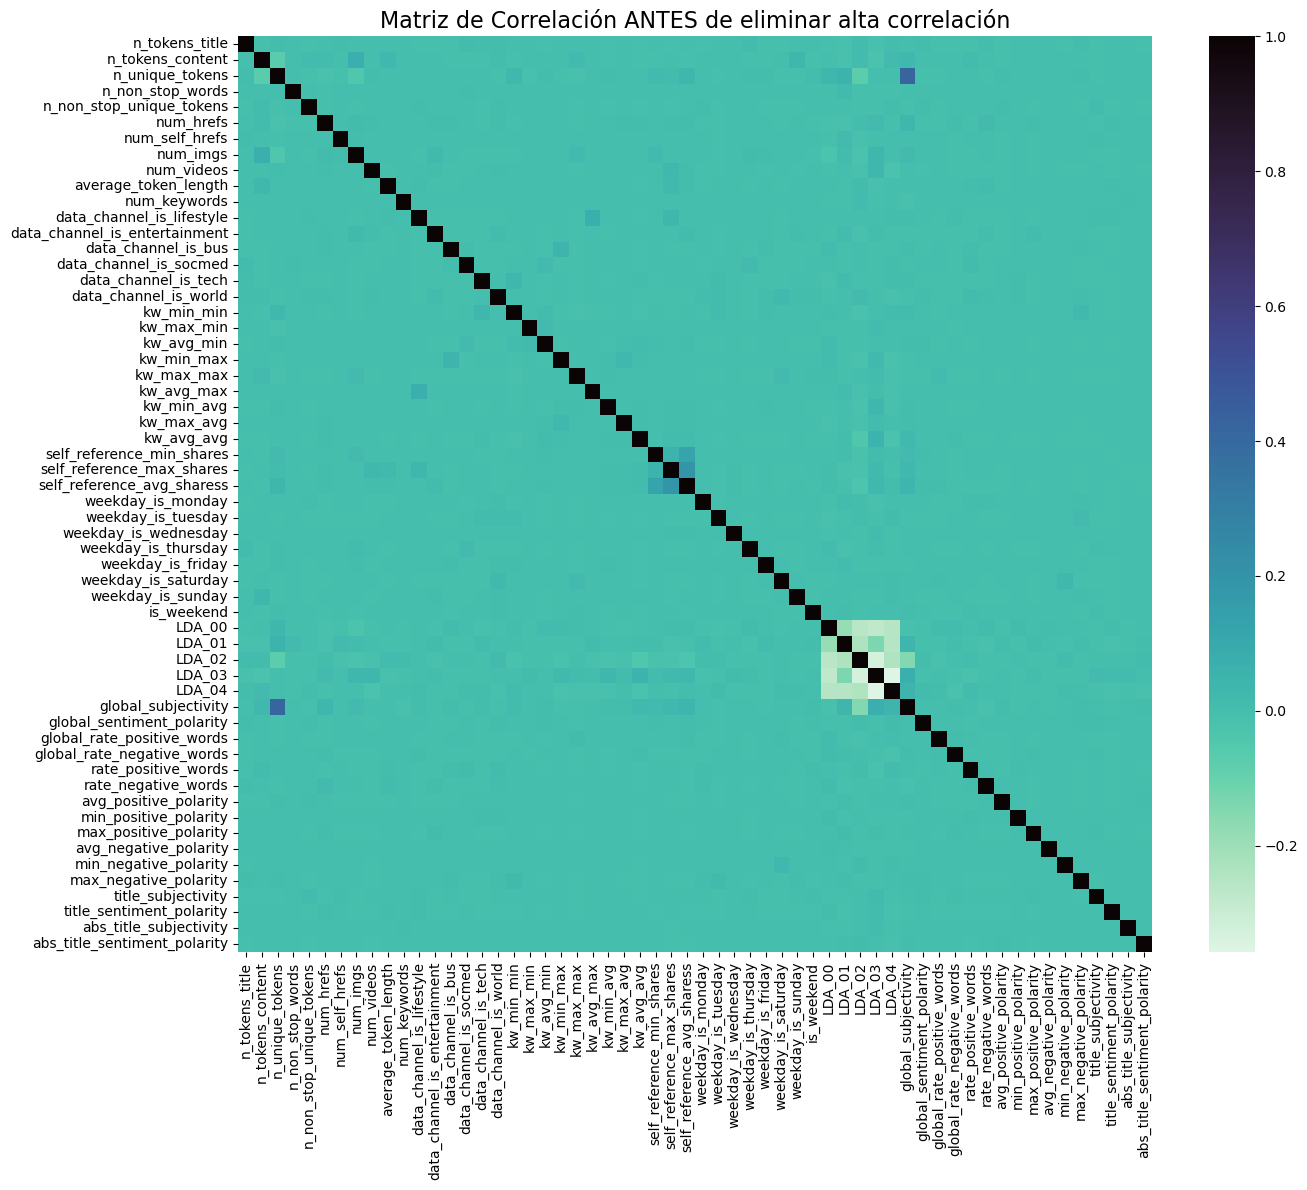

Heatmap 'Matriz de Correlación ANTES de eliminar alta correlación' generado.

--- Buscando características altamente correlacionadas (umbral > 0.9) ---
No se encontraron características nuevas altamente correlacionadas para eliminar.

--- Generando Heatmap: Matriz de Correlación DESPUÉS de eliminar alta correlación ---
Heatmap guardado en: ../docs/06_corr_matrix_after.png


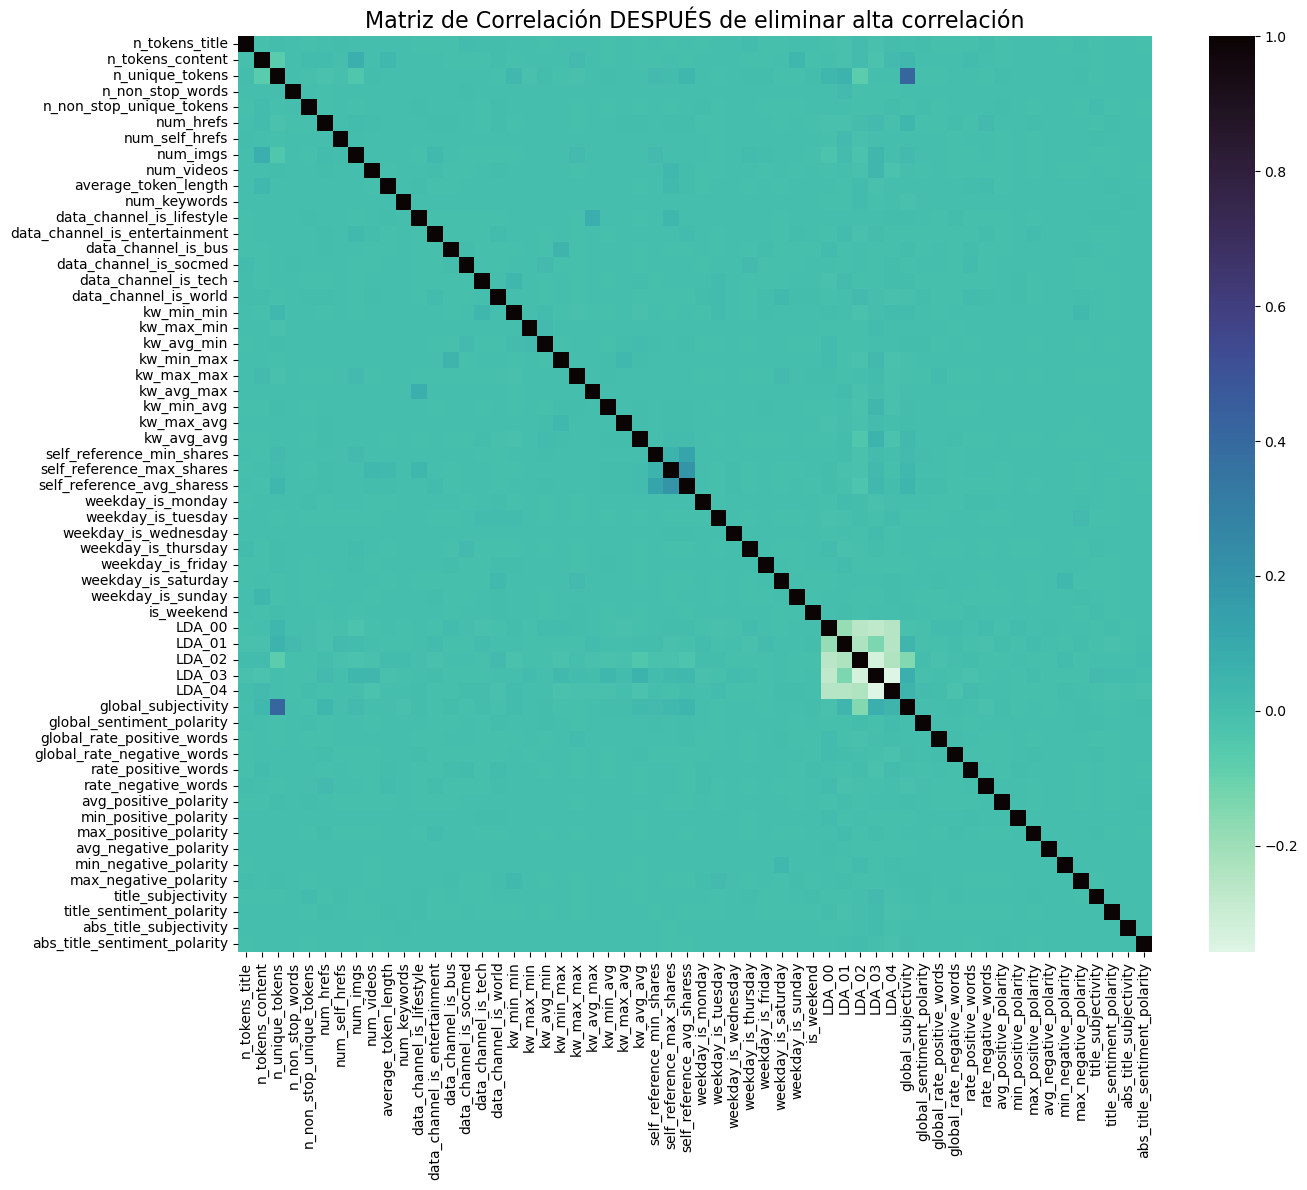

Heatmap 'Matriz de Correlación DESPUÉS de eliminar alta correlación' generado.

--- Generando Reporte de Profiling: Reporte 3: Set de Entrenamiento (Train, Final) ---
Guardando en: ../docs/03_train_set_report.html


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 59/59 [00:00<00:00, 70.43it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Reporte '03_train_set_report.html' guardado exitosamente.

--- Generando Reporte de Profiling: Reporte 4: Set de Prueba (Test, Final) ---
Guardando en: ../docs/04_test_set_report.html


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 59/59 [00:00<00:00, 246.58it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Reporte '04_test_set_report.html' guardado exitosamente.

Definiendo el Pipeline de Scikit-Learn...
Columnas binarias identificadas: 0
Columnas numéricas no binarias: 58
Pipeline de modelo y preprocesamiento definido exitosamente.
X_train shape: (32008, 58), y_train shape: (32008,)
X_test shape: (8002, 58), y_test shape: (8002,)
FIN DE PREPROCESAMIENTO Y DEFINICIÓN DE PIPELINE

...FLUJO AUTOMATIZADO COMPLETADO.
Verifica la carpeta '../docs/' para los 4 reportes HTML y 2 imágenes PNG.

Columnas totales eliminadas del set de features: ['url', 'timedelta']


In [ ]:
# MAIN

if __name__ == "__main__":
    
    filepath = '../Data/online_news_modified.csv' 
    
    print("\n\n" + "="*40)
    print("INICIANDO FLUJO AUTOMATIZADO REFACTORIZADO v5")
    print("="*40)
    
    model = DataProcessor(filepath)
    
    if model.load_data() is not None:
        model.preprocess_data()
        
        print("\n...FLUJO AUTOMATIZADO COMPLETADO.")
        print(f"Verifica la carpeta '{model.reports_path}' para los 4 reportes HTML y 2 imágenes PNG.")
        print(f"\nColumnas totales eliminadas del set de features: {model.cols_to_drop}")
    else:
        print("Fallo al cargar datos. Terminando script.")